In [2]:
!pip install lightly

In [13]:
import torch
from torch import nn
import torchvision

from lightly.data import LightlyDataset
from lightly.data.collate import VICRegCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from lightly.loss import VICRegLoss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime, date


Загрузим и обучим модель 

In [ ]:

class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

print("Starting Training")
for epoch in range(10):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Проверим на линейной регрессии

In [ ]:
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


Посчитаем f1_score и Accuracy на тесте

In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
for (x0, x1), _1, _2 in test:
  print(model(x0.to(device)).shape)
  print("f1_score: ", f1_score(_1, clf.predict(model(x0.to(device)).cpu().detach().numpy()), average='macro'))
  print("Accuracy: ", accuracy_score(_1, clf.predict(model(x0.to(device)).cpu().detach().numpy())))
  break

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])

f1_score:  0.17236501257303577

Accuracy:  0.17578125


Возьмем более мощную 

In [ ]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_pre = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_pre.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

print("Starting Training")
for epoch in range(10):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_pre(x0)
        z1 = model_pre(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified

Starting Training

epoch: 00, loss: 21.64065

epoch: 01, loss: 21.32167

epoch: 02, loss: 21.13270

epoch: 03, loss: 21.00190

epoch: 04, loss: 20.88132

epoch: 05, loss: 20.77509

epoch: 06, loss: 20.68807

epoch: 07, loss: 20.61629

epoch: 08, loss: 20.54387

epoch: 09, loss: 20.49477


In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

for (x0, x1), _1, _2 in test:
  print(model_pre(x0.to(device)).shape)
  print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
  print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
  break

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])

f1_score:  0.3053117370165934

Accuracy:  0.328125


In [8]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z


def modeler(a={'lambda':[20,25,30], 'mu': [20,25,30], 'nu': [0.9, 1, 1.1]}):
    res = []
    losses_plots = []
    for lamb in a['lambda']:
        for mu in a['mu']:
            for nu in a['nu']:
                loes = []
                print("Experiment with \n lambda: ", lamb, '\n', 'mu_param: ', mu,  '\n', 'nu_param: ', nu, '\n')
                resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
                backbone = nn.Sequential(*list(resnet.children())[:-1])
                model_pre = VICReg(backbone)

                device = "cuda" if torch.cuda.is_available() else "cpu"
                model_pre.to(device)

                cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
                dataset = LightlyDataset.from_torch_dataset(cifar10)
                # or create a dataset from a folder containing images or videos:
                # dataset = LightlyDataset("path/to/folder")

                collate_fn = VICRegCollateFunction(input_size=32)

                dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=256,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True,
                    num_workers=4,
                )

                criterion = VICRegLoss(lambda_param=lamb, mu_param=mu, nu_param=nu)
                optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

                print("Starting Training")
                for epoch in range(10):
                    total_loss = 0
                    for (x0, x1), _, _ in dataloader:
                        x0 = x0.to(device)
                        x1 = x1.to(device)
                        z0 = model_pre(x0)
                        z1 = model_pre(x1)
                        loss = criterion(z0, z1)
                        total_loss += loss.detach()
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    avg_loss = total_loss / len(dataloader)
                    loes.append(avg_loss)
                    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
                
                losses_plots.append(loes)

                clf = LogisticRegression(random_state=0)
                for (x0, x1), _1, _2 in dataloader:
                    clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
                    break


                cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
                testset = LightlyDataset.from_torch_dataset(cifar10_test)
                # or create a dataset from a folder containing images or videos:
                # dataset = LightlyDataset("path/to/folder")

                collate_fn = VICRegCollateFunction(input_size=32)

                test = torch.utils.data.DataLoader(
                    testset,
                    batch_size=256,
                        collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True,
                    num_workers=4,
                )
                for (x0, x1), _1, _2 in test:
                    print(model_pre(x0.to(device)).shape)
                    print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
                    print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
                    break
                res.append((lamb, mu, nu, accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()))))
    return res, losses_plots

In [9]:
result, plo = modeler({'lambda':[20,25,30], 'mu': [25], 'nu': [1]})

Experiment with 
 lambda:  20 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 20.90370
epoch: 01, loss: 20.68126
epoch: 02, loss: 20.52836
epoch: 03, loss: 20.39625
epoch: 04, loss: 20.29251
epoch: 05, loss: 20.18942
epoch: 06, loss: 20.11490
epoch: 07, loss: 20.02499
epoch: 08, loss: 19.96619
epoch: 09, loss: 19.90195


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 2048])
f1_score:  0.3999487556058293
Accuracy:  0.41015625
Experiment with 
 lambda:  25 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 21.64354
epoch: 01, loss: 21.33971
epoch: 02, loss: 21.15562
epoch: 03, loss: 21.00764
epoch: 04, loss: 20.87555
epoch: 05, loss: 20.77958
epoch: 06, loss: 20.69603
epoch: 07, loss: 20.62107
epoch: 08, loss: 20.55271
epoch: 09, loss: 20.47956


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 2048])
f1_score:  0.37170587671988414
Accuracy:  0.375
Experiment with 
 lambda:  30 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 22.17962
epoch: 01, loss: 21.77466
epoch: 02, loss: 21.58730
epoch: 03, loss: 21.42878
epoch: 04, loss: 21.30537
epoch: 05, loss: 21.19534
epoch: 06, loss: 21.11991
epoch: 07, loss: 21.04643
epoch: 08, loss: 20.98205
epoch: 09, loss: 20.92097


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 2048])
f1_score:  0.3945801941659357
Accuracy:  0.40234375


In [27]:
nubers = []
for t in range(len(plo)):
    r = []
    for i in range(len(plo[t])):
        r.append(plo[t][i].cpu().detach().numpy())
    nubers.append(r)
data = np.array(nubers)

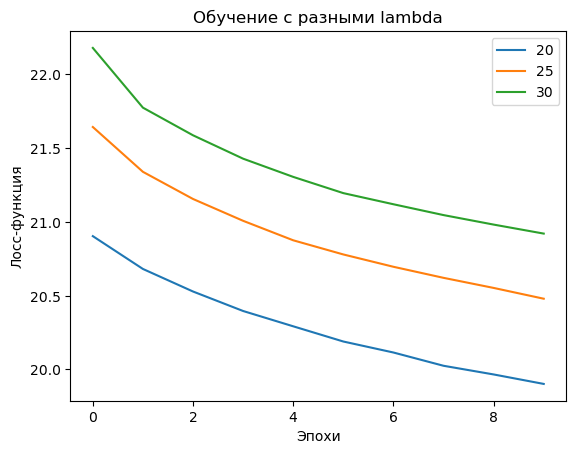

In [46]:
plt.plot(data[0], label="20")
plt.plot(data[1], label="25")
plt.plot(data[2], label="30")
plt.title("Обучение с разными lambda")
plt.ylabel("Лосс-функция")
plt.xlabel("Эпохи")
plt.legend()

In [48]:
acuur = []
for ac in result:
    acuur.append(ac[3])
print('Lambda: ', result[np.argmax(acuur)][0], '; mu param: ', result[np.argmax(acuur)][1],
      '; nu param: ', result[np.argmax(acuur)][2], '\nBest Accuracy: ', result[np.argmax(acuur)][3])

Lambda:  20 ; mu param:  25 ; nu param:  1 
Best Accuracy:  0.41015625
